#                            Movie Recommendation System

Two MovieLens datasets are used here. Link: [https://grouplens.org/datasets/movielens/latest](https://grouplens.org/datasets/movielens/latest/ )

* **The Full Dataset**: Consists of 26,000,000 ratings and 750,000 tag applications applied to 45,000 movies by 270,000 users. Includes tag genome data with 12 million relevance scores across 1,100 tags.
* **The Small Dataset**: Comprises of 100,000 ratings and 1,300 tag applications applied to 9,000 movies by 700 users.

In this project, we will build 4 different recommendation engines based on different ideas and algorithms. They are as follows:

1. **Simple Recommender**: A Simple Recommender uses overall vote count and vote averages to build top movies charts, in general and for a specific genre.
2. **Content Based Filtering**: Content-based filtering uses item features to recommend other items similar to what the user likes, based on their previous actions or explicit feedback.
3. **Collaborative Filtering**: Collaborative filtering is a technique that can filter out items that a user might like on the basis of reactions by similar users. It works by searching a large group of people and finding a smaller set of users with tastes similar to a particular user.
4. **Hybrid Engine**: It brings together the ideas from content and collaborative filterting to build an engine that will give movie suggestions to a particular user.

We will build our simple recommender using movies from the full dataset whereas all personalized recommender systems will make use of the small dataset.

In [1]:
#importing required libraries 
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = None

from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

import warnings; warnings.simplefilter('ignore')

## Simple Popularity Recommendation Model

The model simply do implement generalize recommendation to all user based on popularity of movie. The logic behind the model is that the average audience probably pick or like movies which is critically acclaimed and most popular.This model does not give personalized recommendations based on the user.

Procedure is as follow.

* First sort movies based on ratings and popularity
* Display the top movies of list.
* Using genre argument for the top movies of a particular genre.

In [2]:
data = pd.read_csv('The Movies Dataset/movies_metadata.csv')
data.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [3]:
data['genres'] = data['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] 
                                                                       if isinstance(x, list) else [])
data.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


**IMDB's weighted rating formula**

Mathematically, it is represented as follows:

Weighted Rating (WR) = $(\frac{v}{v + m} . R) + (\frac{m}{v + m} . C)$

where,

v is the number of votes for the movie\
m is the minimum votes required to be listed in the chart\
R is the average rating of the movie\
C is the mean vote across the whole report\
Now, determine an cutoff value for m, the minimum votes required to be listed in the chart.

In this model used cutoff is **95th percent** that means for a movie to feature in the top N must have more votes than at least 95% of the movies in the list.

In [4]:
# Claculation of c 
vote_averages = data[data['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
C

5.244896612406511

In [5]:
## Claculation of m
vote_counts = data[data['vote_count'].notnull()]['vote_count'].astype('int')
m = vote_counts.quantile(0.95)
m

434.0

In [6]:
# extracting release year from release_date
data['year'] = pd.to_datetime(data['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] 
                                                                           if x != np.nan else np.nan)
data['year'].head()

0    1995
1    1995
2    1995
3    1995
4    1995
Name: year, dtype: object

### Getting Qualified Cutoff Movies

In [7]:
col_list = ['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']
qualified = data[(data['vote_count'] >= m) & (data['vote_count'].notnull()) & (data['vote_average'].notnull())][col_list]

# converting vote_count and vote_average colums to integer
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(2274, 6)


Findings as follow:

1. For consideration in the chart, a movie has to have at least 434 votes.
2. the average rating for a movie is 5.244 on a scale of 10.
3. 2274 movies qualifies to be on the chart.

### Calculating weighted ratings and making top 250 chart

In [8]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [9]:
qualified['weighted_rating'] = qualified.apply(weighted_rating, axis=1)
qualified = qualified.sort_values('weighted_rating', ascending=False).head(250)

### Top 10 Movies

In [10]:
qualified.head(10)

,title,year,vote_count,vote_average,popularity,genres,weighted_rating
15480,Inception,2010,14075,8,29.1081,"[Action, Thriller, Science Fiction, Mystery, A...",7.917588
12481,The Dark Knight,2008,12269,8,123.167,"[Drama, Action, Crime, Thriller]",7.905871
22879,Interstellar,2014,11187,8,32.2135,"[Adventure, Drama, Science Fiction]",7.897107
2843,Fight Club,1999,9678,8,63.8696,[Drama],7.881753
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.0707,"[Adventure, Fantasy, Action]",7.871787
292,Pulp Fiction,1994,8670,8,140.95,"[Thriller, Crime]",7.868660
314,The Shawshank Redemption,1994,8358,8,51.6454,"[Drama, Crime]",7.864000
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.3244,"[Adventure, Fantasy, Action]",7.861927
351,Forrest Gump,1994,8147,8,48.3072,"[Comedy, Drama, Romance]",7.860656
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.4235,"[Adventure, Fantasy, Action]",7.851924


### Plotting  Bar Graph To Depict The Top Movies

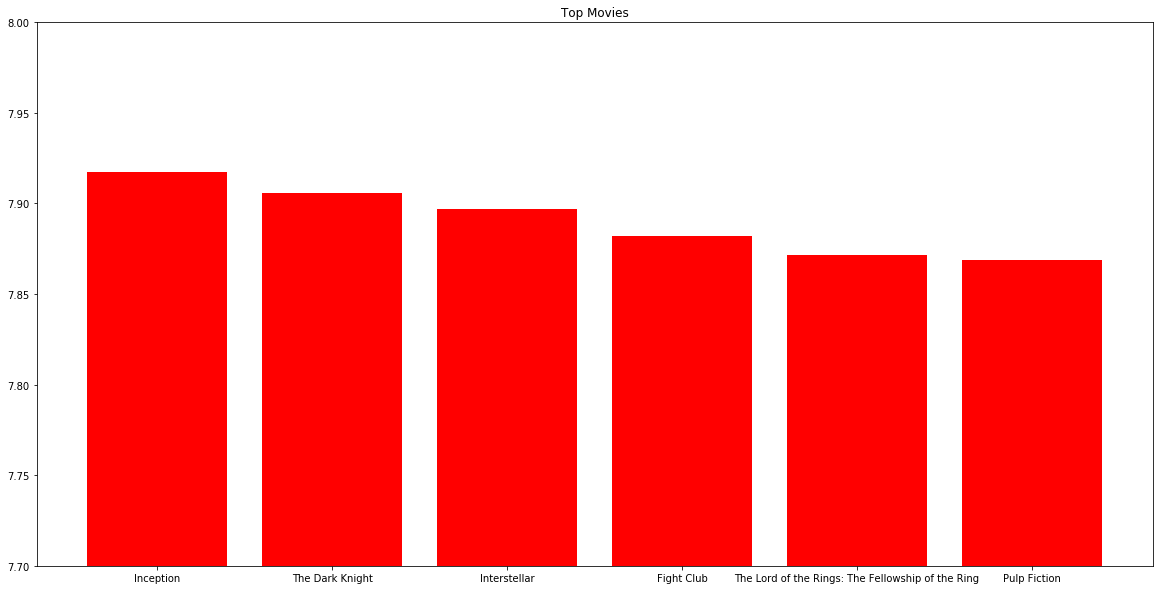

In [11]:
plt.figure(figsize=(20,10))
plt.bar(qualified['title'].head(6),qualified['weighted_rating'].head(6),align='center',color='red')
plt.title("Top Movies")
plt.ylim((7.7,8))
plt.show()

Now, building list for particular **genres**. For that, cutoff is relaxed to **85%** instead of 95.

In [12]:
temp = data.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
temp.name = 'genre'
gen_data = data.drop('genres', axis=1).join(temp)
gen_data.head()

,adult,belongs_to_collection,budget,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,genre
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995,Animation
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995,Comedy
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995,Family
1,False,NaN,65000000,NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,Adventure
1,False,NaN,65000000,NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,Fantasy


In [13]:
def make_toplist(genre, percentile=0.85):
    df = gen_data[gen_data['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    col_list = ['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genre']
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][col_list]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    qualified['weighted_rating'] = qualified.apply(lambda x: 
                                                   (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), 
                                                   axis=1)
    qualified = qualified.sort_values('weighted_rating', ascending=False).head(250)
    
    return qualified

### Top 10 Adventure Movies

In [14]:
make_toplist('Adventure').head(10)

,title,year,vote_count,vote_average,popularity,genre,weighted_rating
15480,Inception,2010,14075,8,29.1081,Adventure,7.906526
22879,Interstellar,2014,11187,8,32.2135,Adventure,7.883426
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.0707,Adventure,7.854939
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.3244,Adventure,7.843867
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.4235,Adventure,7.832647
256,Star Wars,1977,6778,8,42.1497,Adventure,7.812801
1225,Back to the Future,1985,6239,8,25.7785,Adventure,7.797828
1154,The Empire Strikes Back,1980,5998,8,19.471,Adventure,7.790329
5481,Spirited Away,2001,3968,8,41.0489,Adventure,7.695056
9698,Howl's Moving Castle,2004,2049,8,16.136,Adventure,7.465435


## Content Based Recomendation Model

Limitation of Popularity Model
* It gives the same recommendation to everyone, regardless of the user's personal interest.

Therefore, let's build a model that computes similarity between movies based on certain metrics and suggests movies that are most similar to a particular movie that a user liked. For that we have to consider metadata (or content), hence, it also known as Content Based Filtering.

Two Content Based Recommendation is implemented based on different contents:

* Description Based (content: Movie Overviews and Taglines)
* Meta Data Based (content : Movie Cast, Crew, Keywords and Genre)

In [15]:
small_md = pd.read_csv('The Movies Dataset/links_small.csv')
small_md = small_md[small_md['tmdbId'].notnull()]['tmdbId'].astype('int')

Before extracting small data set, we need to make sure that the ID column of our main dataframe is clean and of type integer. To do this, let us try to perform an integer conversion of our IDs and if an exception is raised,we will replace the ID with NaN. We will then proceed to drop these rows from our dataframe.

In [16]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [17]:
data['id'] = data['id'].apply(convert_int)

In [18]:
data[data['id'].isnull()]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year
19730,- Written by Ørnås,0.065736,/ff9qCepilowshEtG2GYWwzt2bs4.jpg,"[Carousel Productions, Vision View Entertainme...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",NaN,0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Midnight Man,False,6.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
29503,Rune Balot goes to a casino connected to the ...,1.931659,/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg,"[Aniplex, GoHands, BROSTA TV, Mardock Scramble...","[{'iso_3166_1': 'US', 'name': 'United States o...",NaN,0,68.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,NaN,Mardock Scramble: The Third Exhaust,False,7.0,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
35587,Avalanche Sharks tells the story of a bikini ...,2.185485,/zaSf5OG7V8X8gqFvly88zDdRm46.jpg,"[Odyssey Media, Pulser Productions, Rogue Stat...","[{'iso_3166_1': 'CA', 'name': 'Canada'}]",NaN,0,82.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Beware Of Frost Bites,Avalanche Sharks,False,4.3,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [19]:
data = data.drop([19730, 29503, 35587])
data['id'] = data['id'].astype('int')

In [20]:
s_data = data[data['id'].isin(small_md)]
s_data.shape

(9099, 25)

**9099** movies avaiable in our small movies metadata dataset

### Description Based System

In [21]:
s_data['tagline'] = s_data['tagline'].fillna('')
s_data['description'] = s_data['overview'] + s_data['tagline']
s_data['description'] = s_data['description'].fillna('')

**Compute TF-IDF matrix**

In [22]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(s_data['description'])
tfidf_matrix.shape

(9099, 268124)

**Cosine Similarity**\
The Cosine Similarity is used to calculate a numeric quantity that denotes the similarity between two movies. Mathematically, it is defined as follows:

$cosine(x,y) = \frac{x. y^\intercal}{||x||.||y||} $

Since the TF-IDF Vectorizer is used, calculating the Dot Product will directly give us the Cosine Similarity Score. Therefore, sklearn's linear_kernel is used instead of cosine_similarities as it's much faster.

In [23]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[0]

array([1.        , 0.00680476, 0.        , ..., 0.        , 0.00344913,
       0.        ])

In [24]:
s_data = s_data.reset_index()
titles = s_data['title']
indices = pd.Series(s_data.index, index=s_data['title'])
indices[:10]

title
Toy Story                      0
Jumanji                        1
Grumpier Old Men               2
Waiting to Exhale              3
Father of the Bride Part II    4
Heat                           5
Sabrina                        6
Tom and Huck                   7
Sudden Death                   8
GoldenEye                      9
dtype: int64

In [25]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:51]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

Let us now try and get the top 10 recommendations for a few movies.

In [26]:
get_recommendations('The Godfather').head(10)

973      The Godfather: Part II
8387                 The Family
3509                       Made
4196         Johnny Dangerously
29               Shanghai Triad
5667                       Fury
2412             American Movie
1582    The Godfather: Part III
4221                    8 Women
2159              Summer of Sam
Name: title, dtype: object

In [27]:
get_recommendations('The Dark Knight').head(10)

7931                      The Dark Knight Rises
132                              Batman Forever
1113                             Batman Returns
8227    Batman: The Dark Knight Returns, Part 2
7565                 Batman: Under the Red Hood
524                                      Batman
7901                           Batman: Year One
2579               Batman: Mask of the Phantasm
2696                                        JFK
8165    Batman: The Dark Knight Returns, Part 1
Name: title, dtype: object

We see that for **The Dark Knight**, our system is able to identify it as a Batman film and subsequently recommend other Batman films as its top recommendations. But unfortunately, that is all this system can do at the moment. This is not of much use to most people as it doesn't take into considerations very important features such as cast, crew, director and genre, which determine the rating and the popularity of a movie. Someone who liked **The Dark Knight** probably likes it more because of **Nolan** and would hate **Batman Forever** and every other substandard movie in the Batman Franchise.

Therefore, we are going to use much more suggestive metadata than overview and tagline. In the next subsection, Let's build a more sophisticated recommender that takes genre, keywords, cast and crew into consideration.

### Metadata Based Recommendation

In [28]:
credits = pd.read_csv('The Movies Dataset/credits.csv')
keywords = pd.read_csv('The Movies Dataset/keywords.csv')

In [29]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
data.shape

(45463, 25)

In [30]:
# merging require details with our main dataframe 
data = data.merge(credits, on='id')
data = data.merge(keywords, on='id')
data.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [31]:
s_data = data[data['id'].isin(small_md)]
s_data.shape

(9219, 28)

We now have our cast, crew, genres and credits, all in one dataframe. Let us wrangle this a little more using the following intuitions:

* Crew: From the crew, we will only pick the director as our feature.
* Cast: Choosing cast is a little more tricky. Lesser known actors and minor roles do not really affect people's opinion of a movie. Therefore, we must only select the major characters and their respective actors. Arbitrarily we will choose the top 3 actors that appear in the credits list.

In [32]:
s_data['cast'] = s_data['cast'].apply(literal_eval)
s_data['crew'] = s_data['crew'].apply(literal_eval)
s_data['keywords'] = s_data['keywords'].apply(literal_eval)
s_data['cast_size'] = s_data['cast'].apply(lambda x: len(x))
s_data['crew_size'] = s_data['crew'].apply(lambda x: len(x))

In [33]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

s_data['director'] = s_data['crew'].apply(get_director)

In [34]:
s_data['cast']=s_data['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x,list) else [])
s_data['cast']=s_data['cast'].apply(lambda x: x[:3] if len(x)>=3 else x)
s_data['cast']

0                      [Tom Hanks, Tim Allen, Don Rickles]
1           [Robin Williams, Jonathan Hyde, Kirsten Dunst]
2               [Walter Matthau, Jack Lemmon, Ann-Margret]
3        [Whitney Houston, Angela Bassett, Loretta Devine]
4               [Steve Martin, Diane Keaton, Martin Short]
                               ...                        
40952      [Sidney Poitier, Wendy Crewson, Jay O. Sanders]
41172            [Akshay Kumar, Ileana D'Cruz, Esha Gupta]
41225            [Hrithik Roshan, Pooja Hegde, Kabir Bedi]
41391    [Hiroki Hasegawa, Yutaka Takenouchi, Satomi Is...
41669           [Paul McCartney, Ringo Starr, John Lennon]
Name: cast, Length: 9219, dtype: object

In [35]:
s_data['keywords'] = s_data['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
s_data['keywords']

0        [jealousy, toy, boy, friendship, friends, riva...
1        [board game, disappearance, based on children'...
2        [fishing, best friend, duringcreditsstinger, o...
3        [based on novel, interracial relationship, sin...
4        [baby, midlife crisis, confidence, aging, daug...
                               ...                        
40952                           [friendship, brick making]
41172                                          [bollywood]
41225                                          [bollywood]
41391    [monster, godzilla, giant monster, destruction...
41669                                 [music, documentary]
Name: keywords, Length: 9219, dtype: object

The approach to building the recommendation is going to be extremely hacky. The plan on doing is creating a metadata dump for every movie which consists of genres, director, main actors and keywords. I then use a Count Vectorizer to create our count matrix as we did in the Description Recommender. The remaining steps are similar to what we did earlier, we calculate the cosine similarities and return movies that are most similar.

These are steps I follow in the preparation of genres and credits data:

1. Strip spaces and convert to lowercase from all our features. This way, engine will not confuse between Johnny Depp and Johnny Galecki.
2. Mention director 2 times to give it more weight relative to the entire cast.

In [36]:
s_data['cast'] = s_data['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [37]:
s_data['director'] = s_data['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
s_data['director'] = s_data['director'].apply(lambda x: [x,x])

In [38]:
s_data[['director','cast']]

,director,cast
0,"[johnlasseter, johnlasseter]","[tomhanks, timallen, donrickles]"
1,"[joejohnston, joejohnston]","[robinwilliams, jonathanhyde, kirstendunst]"
2,"[howarddeutch, howarddeutch]","[waltermatthau, jacklemmon, ann-margret]"
3,"[forestwhitaker, forestwhitaker]","[whitneyhouston, angelabassett, lorettadevine]"
4,"[charlesshyer, charlesshyer]","[stevemartin, dianekeaton, martinshort]"
...,...,...
40952,"[greggchampion, greggchampion]","[sidneypoitier, wendycrewson, jayo.sanders]"
41172,"[tinusureshdesai, tinusureshdesai]","[akshaykumar, ileanad'cruz, eshagupta]"
41225,"[ashutoshgowariker, ashutoshgowariker]","[hrithikroshan, poojahegde, kabirbedi]"
41391,"[hideakianno, hideakianno]","[hirokihasegawa, yutakatakenouchi, satomiishih..."


**Keywords**

We will do a small amount of pre-processing of our keywords before putting them to any use. As a first step, we calculate the frequenct counts of every keyword that appears in the dataset.

In [39]:
s = s_data.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

In [40]:
s=s.value_counts()
s[:5]

independent film        610
woman director          550
murder                  399
duringcreditsstinger    327
based on novel          318
Name: keyword, dtype: int64

In [41]:
s=s[s>1]

Keywords occur in frequencies ranging from 1 to 610. We do not have any use for keywords that occur only once. Therefore, these can be safely removed.

Finally, we will convert every word to its stem so that words such as *trees* and *tree* are considered the same.

In [42]:
stemmer = SnowballStemmer('english')
stemmer.stem('trees')

'tree'

In [43]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [44]:
s_data['keywords'] = s_data['keywords'].apply(filter_keywords)
s_data['keywords'] = s_data['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
s_data['keywords'] = s_data['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [45]:
s_data['soup'] = s_data['keywords'] + s_data['cast'] + s_data['director'] + s_data['genres']
s_data['soup'] = s_data['soup'].apply(lambda x: ' '.join(x))
s_data['soup'].head(5)

0    jealousi toy boy friendship friend rivalri boy...
1    boardgam disappear basedonchildren'sbook newho...
2    fish bestfriend duringcreditssting waltermatth...
3    basedonnovel interracialrelationship singlemot...
4    babi midlifecrisi confid age daughter motherda...
Name: soup, dtype: object

In [46]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(s_data['soup'])

In [47]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [48]:
s_data = s_data.reset_index()
titles = s_data['title']
indices = pd.Series(s_data.index, index=s_data['title'])

We will reuse the get_recommendations function that we had written earlier. Since our cosine similarity scores have changed, we expect it to give us different (and probably better) results. Let us check for **The Dark Knight** again and see what recommendations I get this time around.

In [49]:
get_recommendations('The Dark Knight').head(10)

8031                 The Dark Knight Rises
6218                         Batman Begins
7659            Batman: Under the Red Hood
6623                          The Prestige
1134                        Batman Returns
8927               Kidnapping Mr. Heineken
5943                              Thursday
1260                        Batman & Robin
2085                             Following
9024    Batman v Superman: Dawn of Justice
Name: title, dtype: object

The recommendations seem to have recognized other **Christopher Nolan** movies (due to the high weightage given to director) and put them as top recommendations. Person enjoyed watching **The Dark Knight** as well as some of the other ones in the list including **Batman Begins**, **The Prestige** and **The Dark Knight Rises**.

In [50]:
get_recommendations('Pulp Fiction').head(10)

1381         Jackie Brown
8905    The Hateful Eight
5200    Kill Bill: Vol. 2
4595                Basic
4764             S.W.A.T.
898        Reservoir Dogs
6939              Cleaner
4903    Kill Bill: Vol. 1
231         Kiss of Death
4306       The 51st State
Name: title, dtype: object

**Popularity and Ratings**

One thing that we notice about our recommendation system is that it recommends movies regardless of ratings and popularity. It is true that Batman and Robin has a lot of similar characters as compared to The Dark Knight but it was a terrible movie that shouldn't be recommended to anyone.

Therefore, we will add a mechanism to remove bad movies and return movies which are popular and have had a good critical response.

I will take the top 50 movies based on similarity scores and calculate the vote of the **60th percentile** movie. Then, using this as the value of $m$, we will calculate the weighted rating of each movie using IMDB's formula like we did in the Simple Recommender section.

In [51]:
def improved_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:51]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = s_data.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [52]:
improved_recommendations('The Dark Knight')

,title,vote_count,vote_average,year,wr
7648,Inception,14075,8,2010,7.917588
6623,The Prestige,4510,8,2006,7.758148
8031,The Dark Knight Rises,9263,7,2012,6.921448
6218,Batman Begins,7511,7,2005,6.904127
524,Batman,2145,7,1989,6.704647
1031,M,465,8,1931,6.669950
7659,Batman: Under the Red Hood,459,7,2010,6.147016
2085,Following,363,7,1998,6.044272
1134,Batman Returns,1706,6,1992,5.846862
4145,Insomnia,1181,6,2002,5.797081


In [53]:
improved_recommendations('Pulp Fiction')

,title,vote_count,vote_average,year,wr
898,Reservoir Dogs,3821,8,1992,7.718986
7280,Inglourious Basterds,6598,7,2009,6.891679
4903,Kill Bill: Vol. 1,5091,7,2003,6.862133
8905,The Hateful Eight,4405,7,2015,6.842588
5200,Kill Bill: Vol. 2,4061,7,2004,6.830542
1381,Jackie Brown,1580,7,1997,6.621790
4185,Road to Perdition,1102,7,2002,6.504092
8110,The Raid,1076,7,2011,6.495553
8408,Fast & Furious 6,5282,6,2013,5.942667
8390,Pain & Gain,1595,6,2013,5.838485


## Collaborative Filtering

Limitation of content based recommendation:

* It is only capable of suggesting movies which are close to a certain movie. That is, it is not capable of capturing interest and providing recommendations across genres.

* It doesn't capture the personal intrest and biases of a user. Anyone querying on model for recommendations based on a movie will receive the same recommendations for that movie, regardless of who he is.

Therefore, in this section, we will use a technique called **Collaborative Filtering** to make recommendations to movie watchers. Collaborative Filtering is based on the idea that users similar to a me can be used to predict how much I will like a particular product or service those users have used/experienced but I have not.

We will use the **Surprise library** that used extremely powerful algorithms like Singular Value Decomposition (SVD) to minimise RMSE (Root Mean Square Error) and give great recommendations.

**Single Value Decomposition**

SVD is a Matrix Factorization techniques are usually more effective because they allow us to discover the latent features underlying the interactions between users and items.\
Singular value decomposition takes a rectangular matrix of gene expression data (defined as A, where A is a n x p matrix) in which the n rows represents the genes, and the p columns represents the experimental conditions. The SVD theorem states:

**A(nxp) = U(nxn) S(nxp) VT(pxp)**

In [54]:
reader = Reader()

In [55]:
ratings = pd.read_csv('The Movies Dataset/ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [56]:
data_svd = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [57]:
svd = SVD()
cross_validate(svd, data_svd, measures=['RMSE', 'MAE'],cv=5)

{'test_rmse': array([0.89826148, 0.88695315, 0.90256767, 0.89768851, 0.8975816 ]),
 'test_mae': array([0.69175917, 0.68263199, 0.69082404, 0.69237837, 0.69182768]),
 'fit_time': (5.294832944869995,
  4.732484340667725,
  4.817975997924805,
  4.780365943908691,
  4.870541572570801),
 'test_time': (0.15854811668395996,
  0.26918506622314453,
  0.1463923454284668,
  0.1430356502532959,
  0.14285016059875488)}

### Dataset Training

In [58]:
trainset = data_svd.build_full_trainset()
svd.fit(trainset)

In [59]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


### Prediction

In [60]:
svd.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.8012503086411398, details={'was_impossible': False})

For movie with **ID 302**, we get an estimated prediction of **2.801**. One startling feature of this recommender system is that it doesn't care what the movie is (or what it contains). It works purely on the basis of an assigned movie ID and tries to predict ratings based on how the other users have predicted the movie.

## Hybrid Recommender

We build a simple hybrid recommender that brings together techniques we have implemented in the content based and collaborative filter based engines. This is how it will work:

* Input: User ID and the Title of a Movie
* Output: Similar movies sorted on the basis of expected ratings by that particular user.

In [61]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [62]:
id_map = pd.read_csv('The Movies Dataset/links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(s_data[['title', 'id']], on='id').set_index('title')

In [63]:
indices_map = id_map.set_index('id')

In [64]:
def hybrid(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    #print(idx)
    movie_id = id_map.loc[title]['movieId']
    
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = s_data.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'id']]
    movies['est'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [65]:
hybrid(1, 'Avatar')

,title,vote_count,vote_average,year,id,est
1011,The Terminator,4208.0,7.4,1984,218,3.143528
974,Aliens,3282.0,7.7,1986,679,3.018330
2014,Fantastic Planet,140.0,7.6,1973,16306,2.955408
522,Terminator 2: Judgment Day,4274.0,7.7,1991,280,2.940976
8658,X-Men: Days of Future Past,6155.0,7.5,2014,127585,2.923440
1668,Return from Witch Mountain,38.0,5.6,1978,14822,2.912437
922,The Abyss,822.0,7.1,1989,2756,2.909328
8401,Star Trek Into Darkness,4479.0,7.4,2013,54138,2.902374
2834,Predator,2129.0,7.3,1987,106,2.874550
831,Escape to Witch Mountain,60.0,6.5,1975,14821,2.813701


In [66]:
hybrid(500, 'Avatar')

,title,vote_count,vote_average,year,id,est
2014,Fantastic Planet,140.0,7.6,1973,16306,3.380393
7705,Alice in Wonderland,8.0,5.4,1933,25694,3.300709
2834,Predator,2129.0,7.3,1987,106,3.231980
1621,Darby O'Gill and the Little People,35.0,6.7,1959,18887,3.206367
974,Aliens,3282.0,7.7,1986,679,3.190959
8401,Star Trek Into Darkness,4479.0,7.4,2013,54138,3.126198
8658,X-Men: Days of Future Past,6155.0,7.5,2014,127585,3.101232
7088,Star Wars: The Clone Wars,434.0,5.8,2008,12180,3.089294
4966,Hercules in New York,63.0,3.7,1969,5227,2.929775
1011,The Terminator,4208.0,7.4,1984,218,2.922517


We see that for our hybrid recommender, we get different recommendations for different users although the movie is the same. Hence, our recommendations are more personalized and tailored towards particular users.

## Conclusion

In this notebook, we have built 4 different recommendation engines based on different ideas and algorithms. They are as follows:

1. **Simple Recommender**: This system used overall TMDB Vote Count and Vote Averages to build Top Movies charts, in general and for a specific genre. The IMDB Weighted Rating System was used to calculate ratings on which the sorting was finally performed.
2. **Content Based Recommender**: We built two content based engines; one that took movie overview and taglines as input and the other which took metadata such as cast, crew, genre and keywords to come up with predictions. We also deviced a simple filter to give greater preference to movies with more votes and higher ratings.
3. **Collaborative Filtering**: We used the powerful Surprise Library to build a collaborative filter based on single value decomposition. The RMSE obtained was less than 1 and the engine gave estimated ratings for a given user and movie.
4. **Hybrid Engine**: We brought together ideas from content and collaborative filterting to build an engine that gave movie suggestions to a particular user based on the estimated ratings that it had internally calculated for that user